In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color
from time import time
import math

In [13]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    
    dcm = pydicom.dcmread(filename)
    age = int(dcm.PatientAge)
    if age < 2 or age > 90:
        print(f'Image {filename} rejected, Invalid Age {age} detected')
        return None
    body_part = (dcm.BodyPartExamined)
    if body_part not in ['CHEST', 'chest']:
        print(f'Image {filename} rejected, Invalid BodyPart {body_part} Detected')
        return None
    pos = dcm.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'Image {filename} rejected, invalid Positioning {pos} detected')
        return None
    mod = dcm.Modality
    if mod != 'DX':
        return None
    return dcm.pixel_array
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    if len(img.shape) == 3:
        img = color.rgb2gray(img)
    resized_img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)
    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # todo
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)

    # load weights into new model
    model.load_weights(weight_path)
    print(f"Model loaded: {model}")
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    # todo
    pred = model.predict(img)
    prediction = pred >  thresh
    return prediction[0][0]

def show_image_distr(img):
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=256)
    plt.show()

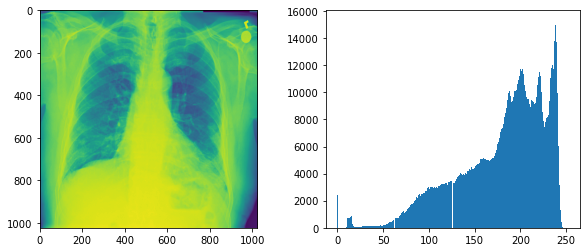

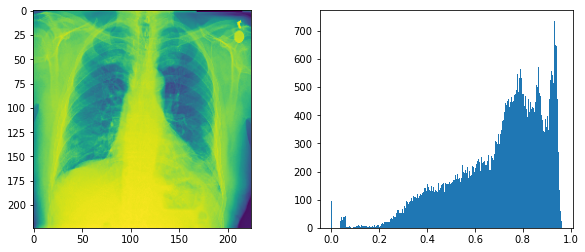

In [14]:
img_example = check_dicom('test1.dcm')
show_image_distr(img_example)
img_example_proc = preprocess_image(img_example, -1, -1, (1, 224, 224, 3))[0, :, :, 0]
show_image_distr(img_example_proc)

In [15]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'model.json'
weight_path = 'pneumonia_classfication_model.best-weights.hdf5'

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = -1 # loads the mean image value they used during training preprocessing
img_std = -1 # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path) #loads model
thresh = 0.3 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)

Model loaded: <keras.engine.sequential.Sequential object at 0x7f3e12f32f90>
True
True
True
Image test4.dcm rejected, Invalid BodyPart RIBCAGE Detected
Image test6.dcm rejected, invalid Positioning XX detected
